In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.7 

In [12]:

#Importing the required header files
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt

import torchsummary
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torchviz import make_dot

from torchvision.models.resnet import ResNet18_Weights

import os
import argparse

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0

In [4]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:01<00:00, 98992158.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

  def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
def resnet_model():
  return ResNet(BasicBlock, [2, 2, 3, 3])

In [7]:
#calculating total number of trainable parameters
model = resnet_model()
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_trainable_params)

4273706


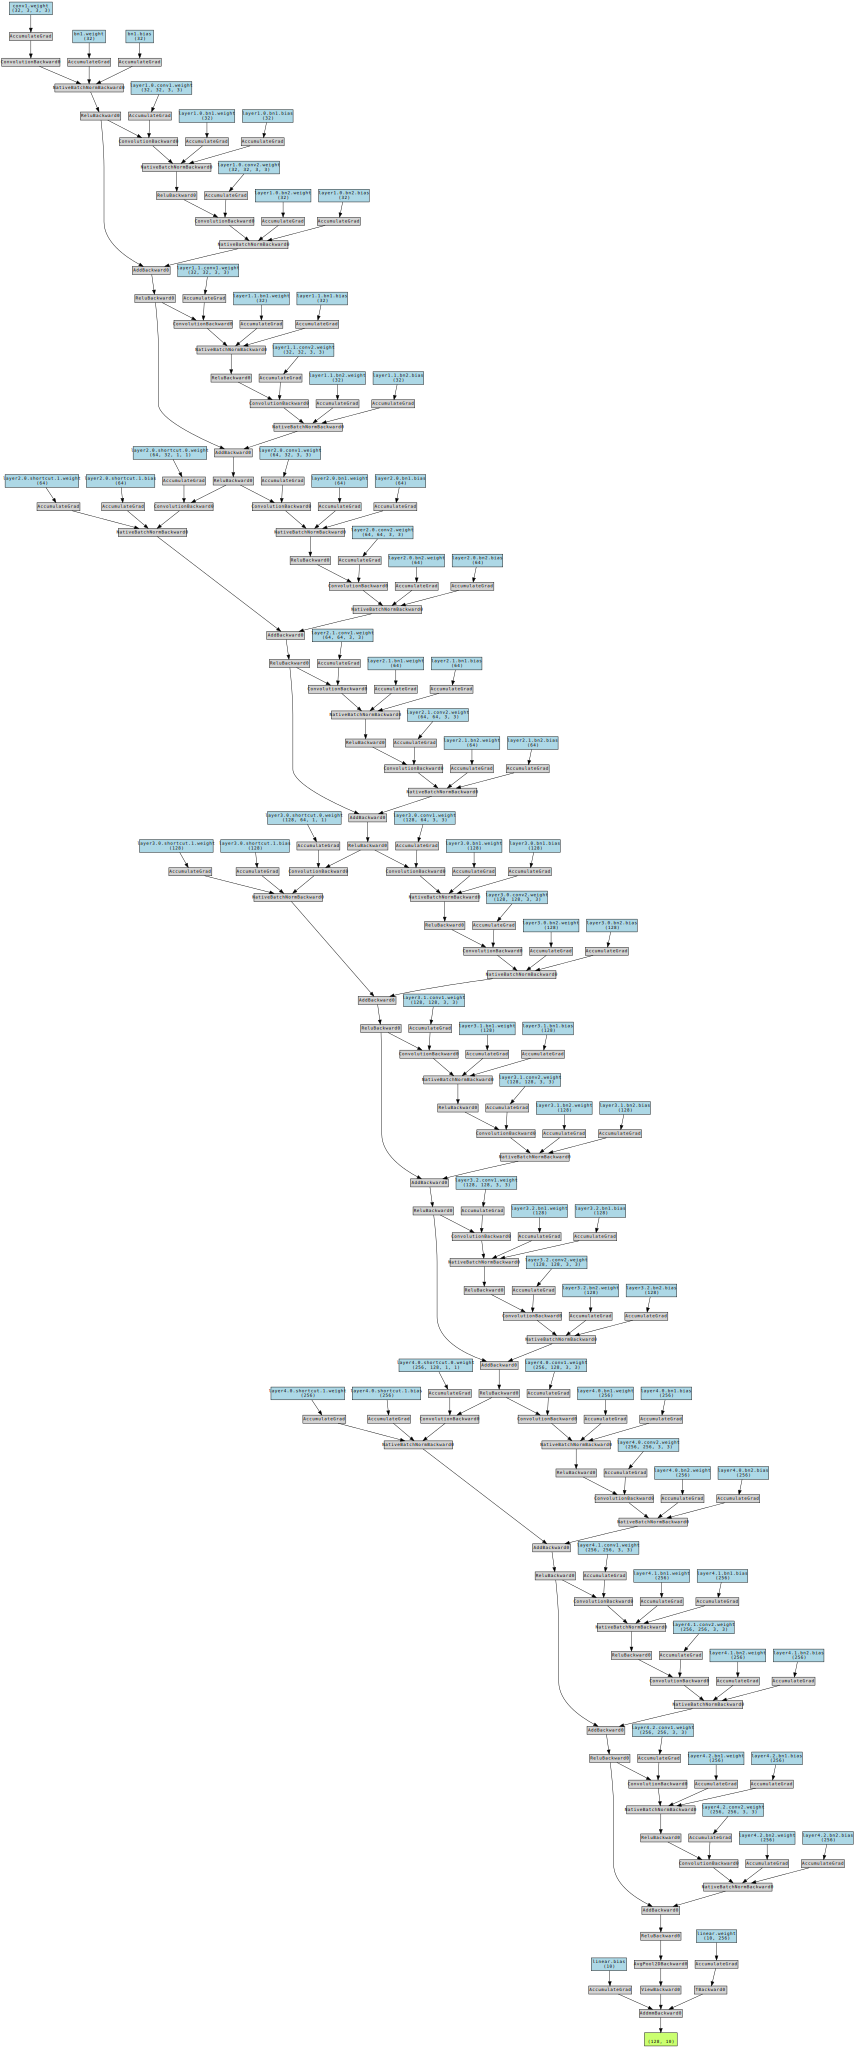

In [8]:
#Figure for Architecture of the model
x = iter(trainloader)
images, label = x.__next__()
y = model(images)
make_dot(y, params=dict(model.named_parameters()))

In [9]:
#Architecture of the model
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

In [10]:
print('==> Building model..')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)            #Using the ADAM optimizer
scheduler = CosineAnnealingLR(optimizer, T_max=200)
train_loss_history = []
train_accuracy = []
test_loss_history = []
test_accuracy = []

==> Building model..


In [13]:
num_epoch = 100
for epoch in range(0, num_epoch):
    print('\nEpoch:', epoch+1)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)          #Finding the loss
        loss.backward()                             #Backward propagation
        optimizer.step()

        train_loss += (loss.item())         #Calculating the total training loss in this batch
        _, predicted = outputs.max(1)       #Finding the predicted output
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()          #Calculating the accuracy
    train_accuracy.append(100.*correct/total)
    train_loss_history.append(train_loss)
    print('Train Loss: %.3f | Acc: %.3f%%'
          % (train_loss/(batch_idx+1), 100.*correct/total))

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += (loss.item())             #Calculating the total testing loss in this batch
            _, predicted = outputs.max(1)           #Finding the predicted output
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()       #Calculating the accuracy
        test_accuracy.append(100.*correct/total)
        test_loss_history.append(test_loss)
        print('Test Loss: %.3f | Acc: %.3f%%'
          % (test_loss/(batch_idx+1), 100.*correct/total))

    #Saving the best accruracy of the model
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc



Epoch: 1
Train Loss: 0.940 | Acc: 66.666%
Test Loss: 1.101 | Acc: 64.250%
Saving..

Epoch: 2
Train Loss: 0.736 | Acc: 74.276%
Test Loss: 0.698 | Acc: 75.950%
Saving..

Epoch: 3
Train Loss: 0.628 | Acc: 78.110%
Test Loss: 0.800 | Acc: 74.120%

Epoch: 4
Train Loss: 0.552 | Acc: 80.832%
Test Loss: 0.930 | Acc: 71.360%

Epoch: 5
Train Loss: 0.496 | Acc: 82.832%
Test Loss: 0.545 | Acc: 82.240%
Saving..

Epoch: 6
Train Loss: 0.452 | Acc: 84.516%
Test Loss: 0.482 | Acc: 83.420%
Saving..

Epoch: 7
Train Loss: 0.417 | Acc: 85.530%
Test Loss: 0.486 | Acc: 84.080%
Saving..

Epoch: 8
Train Loss: 0.387 | Acc: 86.486%
Test Loss: 0.499 | Acc: 83.880%

Epoch: 9
Train Loss: 0.355 | Acc: 87.596%
Test Loss: 0.512 | Acc: 82.880%

Epoch: 10
Train Loss: 0.336 | Acc: 88.360%
Test Loss: 0.396 | Acc: 86.890%
Saving..

Epoch: 11
Train Loss: 0.315 | Acc: 89.058%
Test Loss: 0.455 | Acc: 84.890%

Epoch: 12
Train Loss: 0.295 | Acc: 89.726%
Test Loss: 0.427 | Acc: 86.320%

Epoch: 13
Train Loss: 0.274 | Acc: 90.468%

KeyboardInterrupt: 

In [14]:
print(best_acc)

91.02


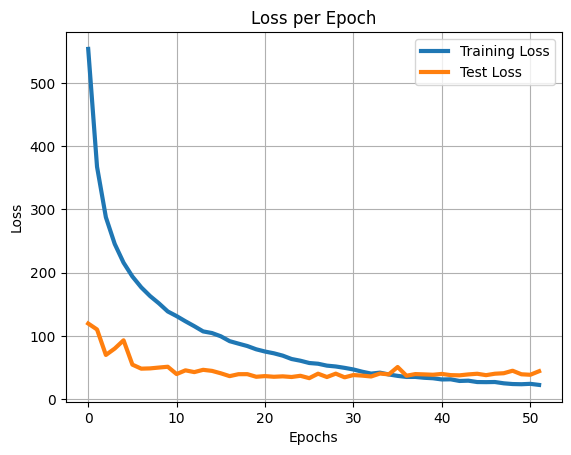

In [18]:
import matplotlib.pyplot as plt
num_epoch = 52
# Plot train loss
plt.plot(range(num_epoch), train_loss_history, '-', linewidth=3, label='Training Loss')
# Plot test loss
plt.plot(range(num_epoch), test_loss_history, '-', linewidth = 3, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()


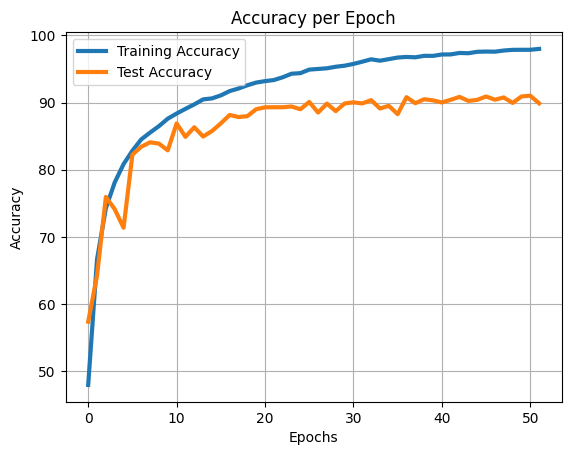

In [19]:

# Plot train accuracy
plt.plot(range(num_epoch), train_accuracy, '-', linewidth=3, label='Training Accuracy')
# Plot test accuracy
plt.plot(range(num_epoch), test_accuracy, '-', linewidth = 3, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()